# Classification de la Glace

In [232]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score




## Extraction des données

In [235]:
df_features = pd.read_csv("data_Features.csv")
df_targets = pd.read_csv("data_Targets.csv")

y = df_targets['Y1']
X = df_features
X.columns



Index(['time', 't2m', 'u10', 'v10', 'SST', 'SIC', 'r1_MAR', 'r2_MAR', 'r3_MAR',
       'r4_MAR', 'r5_MAR'],
      dtype='object')

In [236]:
X.dtypes

# Convertion de la colonne 'time' en format datetime
X['time'] = pd.to_datetime(X['time'], errors='coerce')

X['year'] = X['time'].dt.year
X['month'] = X['time'].dt.month
X['day'] = X['time'].dt.day

# Suppression de la colonne 'time'
X.drop(columns=['time'], inplace=True)



## Analyse descriptive

In [237]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
classe = y.value_counts().reset_index()
print("Information sur la classe à prédire :\n",classe)



Information sur la classe à prédire :
      Y1  count
0     0   2262
1     1     62
2     2     22
3     6     13
4     5     11
..  ...    ...
84   98      1
85   13      1
86   30      1
87   56      1
88  100      1

[89 rows x 2 columns]


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/vy/_lpj4bm56kqfvhjsl70wykwm0000gn/T/ipykernel_34952/2511457614.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


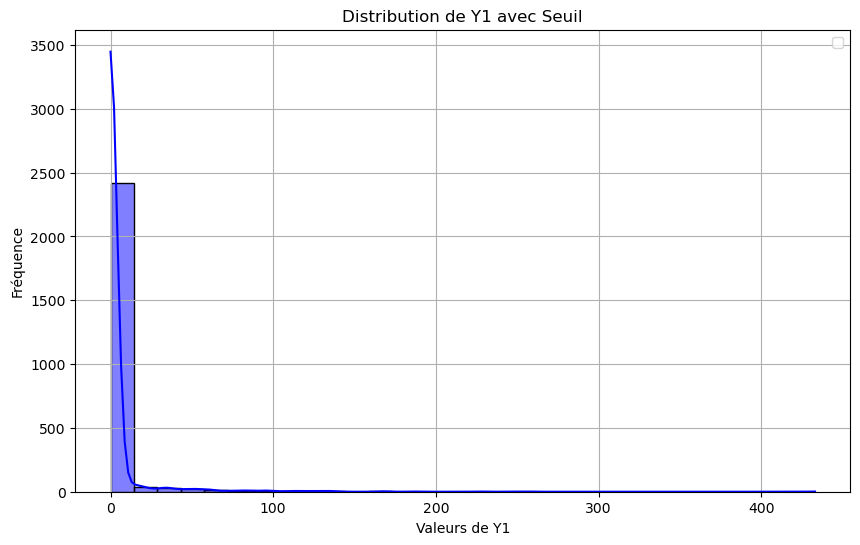

In [241]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(y, bins=30, kde=True, color='blue')
#plt.axvline(optimal_threshold, color='red', linestyle='--', label='Seuil à 250')
plt.title('Distribution de Y1 avec Seuil')
plt.xlabel('Valeurs de Y1')
plt.ylabel('Fréquence')
plt.legend()
plt.grid()
plt.show()

## Determination du seuil optimal pour Random Forest

In [239]:
threshold = y.median()  
y_binary = (y > threshold).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators= 100, random_state=42)
rf_model.fit(X_train, y_train)

y_probs = rf_model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = []

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_f1_score = f1_scores[optimal_idx]

print(f"Seuil optimal basé sur le F1-score : {optimal_threshold:.2f}")
print(f"F1-score au seuil optimal : {optimal_f1_score:.2f}")

y_pred_optimal = (y_probs >= optimal_threshold).astype(int)

acc = accuracy_score(y_test, y_pred_optimal)
print(f'Précision de Random Forest : {acc}')
class_report = classification_report(y_test, y_pred_optimal)
print(f"Rapport de classification :\n {class_report}")

conf_matrix = confusion_matrix(y_test, y_pred_optimal)
print(f"Matrice de confusion :\n {conf_matrix}")


Seuil optimal basé sur le F1-score : 0.59
F1-score au seuil optimal : 0.72
Précision de Random Forest : 0.94921875
Rapport de classification :
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       458
           1       0.85      0.63      0.72        54

    accuracy                           0.95       512
   macro avg       0.90      0.81      0.85       512
weighted avg       0.95      0.95      0.95       512

Matrice de confusion :
 [[452   6]
 [ 20  34]]


## Cross Validation et Hyperparamètres de Random Forest

In [222]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='f1',  
    cv=5,
    n_jobs=-1  
)

grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_
print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleur F1-score lors de la validation croisée : {grid_search.best_score_:.2f}")

y_probs = best_rf_model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = []

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_f1_score = f1_scores[optimal_idx]

print(f"Seuil optimal basé sur le F1-score : {optimal_threshold:.2f}")
print(f"F1-score au seuil optimal : {optimal_f1_score:.2f}")


Meilleurs paramètres : {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
Meilleur F1-score lors de la validation croisée : 0.81
Seuil optimal basé sur le F1-score : 0.48
F1-score au seuil optimal : 0.82


In [223]:
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)

acc = accuracy_score(y_test, y_pred_optimal)
print(f'Précision avec Random Forest optimisé : {acc:.2f}')
class_report = classification_report(y_test, y_pred_optimal)
print(f"Rapport de classification :\n {class_report}")

conf_matrix = confusion_matrix(y_test, y_pred_optimal)
print(f"Matrice de confusion :\n {conf_matrix}")

Précision avec Random Forest optimisé : 0.97
Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       472
           1       0.82      0.82      0.82        40

    accuracy                           0.97       512
   macro avg       0.91      0.91      0.91       512
weighted avg       0.97      0.97      0.97       512

Matrice de confusion :
 [[465   7]
 [  7  33]]


## Determination du seuil optimal pour Bagging

In [240]:
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42)
bagging.fit(X_train, y_train)

# Prédire les probabilités
y_probs_bagging = bagging.predict_proba(X_test)[:, 1]

# Définir les seuils
thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores_bagging = []

# Calculer les F1-scores pour divers seuils
for threshold in thresholds:
    y_pred_bagging = (y_probs_bagging >= threshold).astype(int)
    f1_bagging = f1_score(y_test, y_pred_bagging)
    f1_scores_bagging.append(f1_bagging)  # Utiliser f1_bagging ici

# Identifier le seuil optimal basé sur le F1-score
optimal_idx_bagging = np.argmax(f1_scores_bagging)
optimal_threshold_bagging = thresholds[optimal_idx_bagging]
optimal_f1_score_bagging = f1_scores_bagging[optimal_idx_bagging]


print(f"Seuil optimal basé sur le F1-score : {optimal_threshold_bagging:.2f}")
print(f"F1-score au seuil optimal : {optimal_f1_score_bagging:.2f}")

# Prédire les classes en utilisant le seuil optimal
y_pred_optimal_bagging = (y_probs_bagging >= optimal_threshold_bagging).astype(int)

# Calculer l'exactitude
acc_bagging = accuracy_score(y_test, y_pred_optimal_bagging)
print(f'Précision du modèle : {acc_bagging:.2f}')

# Afficher le rapport de classification
class_report_bagging = classification_report(y_test, y_pred_optimal_bagging)
print(f"Rapport de classification :\n {class_report_bagging}")

# Calculer la matrice de confusion
conf_matrix_bagging = confusion_matrix(y_test, y_pred_optimal_bagging)
print(f"Matrice de confusion :\n {conf_matrix_bagging}")

Seuil optimal basé sur le F1-score : 0.31
F1-score au seuil optimal : 0.67
Précision du modèle : 0.93
Rapport de classification :
               precision    recall  f1-score   support

           0       0.96      0.97      0.96       458
           1       0.69      0.65      0.67        54

    accuracy                           0.93       512
   macro avg       0.82      0.81      0.81       512
weighted avg       0.93      0.93      0.93       512

Matrice de confusion :
 [[442  16]
 [ 19  35]]


## Cross Validation et hyperparamètres pour Bagging

In [227]:
param_grid_bagging = {
    'n_estimators': [10, 50, 100],
    'estimator__max_depth': [None, 10, 20],
    'max_samples': [0.5, 1.0]
}

bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42)

grid_search_bagging = GridSearchCV(
    estimator=bagging_model,
    param_grid=param_grid_bagging,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

grid_search_bagging.fit(X_train, y_train)

best_bagging_model = grid_search_bagging.best_estimator_
print(f"Meilleurs paramètres pour BaggingClassifier : {grid_search_bagging.best_params_}")
print(f"Meilleur F1-score lors de la validation croisée : {grid_search_bagging.best_score_:.2f}")

y_probs_bagging = best_bagging_model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores_bagging = []

for threshold in thresholds:
    y_pred_bagging = (y_probs_bagging >= threshold).astype(int)
    f1_bagging = f1_score(y_test, y_pred_bagging)
    f1_scores_bagging.append(f1_bagging)

optimal_idx_bagging = np.argmax(f1_scores_bagging)
optimal_threshold_bagging = thresholds[optimal_idx_bagging]
optimal_f1_score_bagging = f1_scores_bagging[optimal_idx_bagging]

print(f"Seuil optimal basé sur le F1-score : {optimal_threshold_bagging:.2f}")
print(f"F1-score au seuil optimal : {optimal_f1_score_bagging:.2f}")

y_pred_optimal_bagging = (y_probs_bagging >= optimal_threshold_bagging).astype(int)

acc_bagging = accuracy_score(y_test, y_pred_optimal_bagging)
print(f'Précision du modèle Bagging : {acc_bagging:.2f}')
class_report_bagging = classification_report(y_test, y_pred_optimal_bagging)
print(f"Rapport de classification :\n {class_report_bagging}")

conf_matrix_bagging = confusion_matrix(y_test, y_pred_optimal_bagging)
print(f"Matrice de confusion :\n {conf_matrix_bagging}")


Meilleurs paramètres pour BaggingClassifier : {'estimator__max_depth': None, 'max_samples': 0.5, 'n_estimators': 100}
Meilleur F1-score lors de la validation croisée : 0.81
Seuil optimal basé sur le F1-score : 0.53
F1-score au seuil optimal : 0.84
Précision du modèle Bagging : 0.97
Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       472
           1       0.85      0.82      0.84        40

    accuracy                           0.97       512
   macro avg       0.92      0.91      0.91       512
weighted avg       0.97      0.97      0.97       512

Matrice de confusion :
 [[466   6]
 [  7  33]]


## Determination du seuil pour Decision Tree

In [216]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_probs_dt = dt.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores_dt = []

for threshold in thresholds:
    y_pred_dt = (y_probs_dt >= threshold).astype(int)
    f1_dt = f1_score(y_test, y_pred_dt)
    f1_scores_dt.append(f1_dt) 

optimal_idx_dt = np.argmax(f1_scores_dt)
optimal_threshold_dt = thresholds[optimal_idx_dt]
optimal_f1_score_dt = f1_scores_dt[optimal_idx_dt]


print(f"Seuil optimal basé sur le F1-score : {optimal_threshold_dt:.2f}")
print(f"F1-score au seuil optimal : {optimal_f1_score_dt:.2f}")

y_pred_optimal_dt = (y_probs_dt >= optimal_threshold_dt).astype(int)

acc_dt = accuracy_score(y_test, y_pred_optimal_dt)
print(f'Précision du modèle : {acc_dt:.2f}')

class_report_dt = classification_report(y_test, y_pred_optimal_dt)
print(f"Rapport de classification :\n {class_report_dt}")

conf_matrix_dt = confusion_matrix(y_test, y_pred_optimal_dt)
print(f"Matrice de confusion :\n {conf_matrix_dt}")

Seuil optimal basé sur le F1-score : 0.01
F1-score au seuil optimal : 0.71
Précision du modèle : 0.96
Rapport de classification :
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       472
           1       0.72      0.70      0.71        40

    accuracy                           0.96       512
   macro avg       0.85      0.84      0.84       512
weighted avg       0.95      0.96      0.95       512

Matrice de confusion :
 [[461  11]
 [ 12  28]]


## Determination du seuil pour Extra Trees

In [218]:
et = ExtraTreesClassifier(n_estimators = 100, random_state =42)
et.fit(X_train, y_train)

y_probs_et = dt.predict_proba(X_test)[:, 1]

# Définir les seuils
thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores_et = []

# Calculer les F1-scores pour divers seuils
for threshold in thresholds:
    y_pred_et = (y_probs_et >= threshold).astype(int)
    f1_et = f1_score(y_test, y_pred_et)
    f1_scores_et.append(f1_et)  # Utiliser f1_bagging ici

# Identifier le seuil optimal basé sur le F1-score
optimal_idx_et = np.argmax(f1_scores_et)
optimal_threshold_et = thresholds[optimal_idx_et]
optimal_f1_score_et = f1_scores_et[optimal_idx_et]


print(f"Seuil optimal basé sur le F1-score : {optimal_threshold_et:.2f}")
print(f"F1-score au seuil optimal : {optimal_f1_score_et:.2f}")

# Prédire les classes en utilisant le seuil optimal
y_pred_optimal_et = (y_probs_et >= optimal_threshold_et).astype(int)

# Calculer l'exactitude
acc_et = accuracy_score(y_test, y_pred_optimal_et)
print(f'Précision du modèle : {acc_et:.2f}')

# Afficher le rapport de classification
class_report_et = classification_report(y_test, y_pred_optimal_et)
print(f"Rapport de classification :\n {class_report_et}")

# Calculer la matrice de confusion
conf_matrix_et = confusion_matrix(y_test, y_pred_optimal_et)
print(f"Matrice de confusion :\n {conf_matrix_et}")

Seuil optimal basé sur le F1-score : 0.01
F1-score au seuil optimal : 0.71
Précision du modèle : 0.96
Rapport de classification :
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       472
           1       0.72      0.70      0.71        40

    accuracy                           0.96       512
   macro avg       0.85      0.84      0.84       512
weighted avg       0.95      0.96      0.95       512

Matrice de confusion :
 [[461  11]
 [ 12  28]]


## Cross Validation et hyperparamètres pour Decision Tree

In [228]:
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Initialiser DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42)

# Configuration de la validation croisée avec GridSearchCV
grid_search_dt = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid_dt,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

# Effectuer la recherche de grille
grid_search_dt.fit(X_train, y_train)

# Récupérer le meilleur modèle Decision Tree
best_dt_model = grid_search_dt.best_estimator_
print(f"Meilleurs paramètres pour DecisionTreeClassifier : {grid_search_dt.best_params_}")
print(f"Meilleur F1-score lors de la validation croisée : {grid_search_dt.best_score_:.2f}")

# Prédire les probabilités avec le meilleur modèle Decision Tree
y_probs_dt = best_dt_model.predict_proba(X_test)[:, 1]

# Calculer les F1-scores pour divers seuils
thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores_dt = []

for threshold in thresholds:
    y_pred_dt = (y_probs_dt >= threshold).astype(int)
    f1_dt = f1_score(y_test, y_pred_dt)
    f1_scores_dt.append(f1_dt)

# Identifier le seuil optimal basé sur le F1-score
optimal_idx_dt = np.argmax(f1_scores_dt)
optimal_threshold_dt = thresholds[optimal_idx_dt]
optimal_f1_score_dt = f1_scores_dt[optimal_idx_dt]

print(f"Seuil optimal basé sur le F1-score : {optimal_threshold_dt:.2f}")
print(f"F1-score au seuil optimal : {optimal_f1_score_dt:.2f}")

# Prédire les classes en utilisant le seuil optimal
y_pred_optimal_dt = (y_probs_dt >= optimal_threshold_dt).astype(int)

# Calculer l'exactitude, le rapport de classification et la matrice de confusion
acc_dt = accuracy_score(y_test, y_pred_optimal_dt)
print(f'Précision du modèle Decision Tree : {acc_dt:.2f}')
class_report_dt = classification_report(y_test, y_pred_optimal_dt)
print(f"Rapport de classification :\n {class_report_dt}")

conf_matrix_dt = confusion_matrix(y_test, y_pred_optimal_dt)
print(f"Matrice de confusion :\n {conf_matrix_dt}")

Meilleurs paramètres pour DecisionTreeClassifier : {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Meilleur F1-score lors de la validation croisée : 0.72
Seuil optimal basé sur le F1-score : 0.51
F1-score au seuil optimal : 0.76
Précision du modèle Decision Tree : 0.96
Rapport de classification :
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       472
           1       0.82      0.70      0.76        40

    accuracy                           0.96       512
   macro avg       0.90      0.84      0.87       512
weighted avg       0.96      0.96      0.96       512

Matrice de confusion :
 [[466   6]
 [ 12  28]]


## Cross Validation et hyperparamètres pour Extra Trees

In [229]:
param_grid_et = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

et_model = ExtraTreesClassifier(random_state=42)

grid_search_et = GridSearchCV(
    estimator=et_model,
    param_grid=param_grid_et,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

grid_search_et.fit(X_train, y_train)

best_et_model = grid_search_et.best_estimator_
print(f"Meilleurs paramètres pour ExtraTreesClassifier : {grid_search_et.best_params_}")
print(f"Meilleur F1-score lors de la validation croisée : {grid_search_et.best_score_:.2f}")

y_probs_et = best_et_model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores_et = []

for threshold in thresholds:
    y_pred_et = (y_probs_et >= threshold).astype(int)
    f1_et = f1_score(y_test, y_pred_et)
    f1_scores_et.append(f1_et)

optimal_idx_et = np.argmax(f1_scores_et)
optimal_threshold_et = thresholds[optimal_idx_et]
optimal_f1_score_et = f1_scores_et[optimal_idx_et]

print(f"Seuil optimal basé sur le F1-score : {optimal_threshold_et:.2f}")
print(f"F1-score au seuil optimal : {optimal_f1_score_et:.2f}")

y_pred_optimal_et = (y_probs_et >= optimal_threshold_et).astype(int)

acc_et = accuracy_score(y_test, y_pred_optimal_et)
print(f'Précision du modèle Extra Trees : {acc_et:.2f}')
class_report_et = classification_report(y_test, y_pred_optimal_et)
print(f"Rapport de classification :\n {class_report_et}")

conf_matrix_et = confusion_matrix(y_test, y_pred_optimal_et)
print(f"Matrice de confusion :\n {conf_matrix_et}")

Meilleurs paramètres pour ExtraTreesClassifier : {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Meilleur F1-score lors de la validation croisée : 0.84
Seuil optimal basé sur le F1-score : 0.50
F1-score au seuil optimal : 0.85
Précision du modèle Extra Trees : 0.98
Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       472
           1       0.87      0.82      0.85        40

    accuracy                           0.98       512
   macro avg       0.93      0.91      0.92       512
weighted avg       0.98      0.98      0.98       512

Matrice de confusion :
 [[467   5]
 [  7  33]]


## Tracage des Courbes ROC

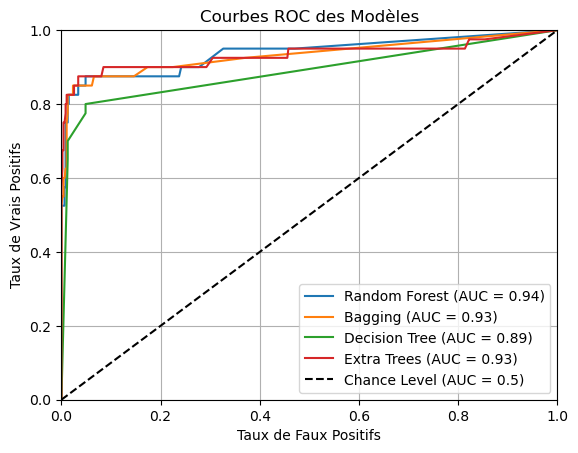

In [230]:
models = {
    "Random Forest": y_probs,
    "Bagging": y_probs_bagging,
    "Decision Tree": y_probs_dt,
    "Extra Trees": y_probs_et,
}

for model_name, y_prob in models.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)  # Calculer l'aire sous la courbe
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance Level (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbes ROC des Modèles')
plt.legend(loc='lower right')
plt.grid()
plt.show()